In [ ]:
http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

In [76]:
## import packages
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
sns.set()
import sklearn.datasets as datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [43]:
plt.figure(figsize=(10.0,8.0))

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [57]:
def bunch_to_dataframe(bunch):
  fnames = bunch.feature_names
  features = fnames.tolist() if isinstance(fnames, np.ndarray) else fnames
  features += ['target']
  return pd.DataFrame(data= np.c_[bunch['data'], bunch['target']],
                 columns=features)

In [61]:
datasets.make_moons?

In [62]:
# Generate a dataset and plot it
np.random.seed(111)

In [63]:
X,y  = datasets.make_moons(n_samples=200,noise = 0.20)

In [65]:
type(X)
type(y)

numpy.ndarray

numpy.ndarray

In [93]:
X[:,0].shape
X[0]
X[:,0][0]
y.shape
y[0]

(200,)

array([ 0.54903278, -0.48204017])

0.5490327823632066

(200,)

1

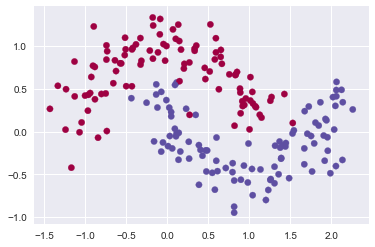

In [107]:
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

### Logistic  Regression

In [89]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf =clf.fit(X,y)
clf

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [90]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5,1,'Logistic Regression')

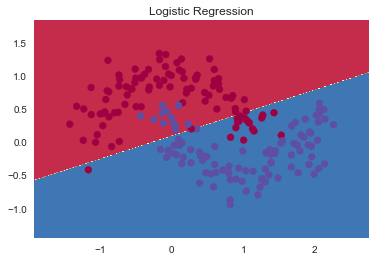

In [92]:
# Plot the decision Boundary
plot_decision_boundary(lambda x:clf.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture then** "moon shape"** of our data.

## Training a Neural Network

### Implementation

In [94]:
num_examples = len(X)  ## Training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output Layer dimensionality

## Gradient descent parametere 
epsilon = 0.01
reg_lambda = 0.01

In [101]:
## Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    """
        Model is the initialization of the weight(w) and bias(b) value as dictionary
        Three things will calculate here
        1. Forward Propagation to calculate our predictions
        2. Calculating the Loss
        3. Add Regularization term to the loss(optional)
    """
    # Get weight and bias value
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    #1 Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    # a2 = softmax(X2)
    exp_scores = np.exp(z2)
    softmax_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    #2. calculating the loss
    correct_logprobs = -np.log(softmax_probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    #3. Add Regularization term to loss
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [102]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)
    

In [103]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

## A network with a hidden layer of size 3
Let's see what happens if we train a network with a hidden layer size of 3.

Loss after iteration 0: 0.436198
Loss after iteration 1000: 0.045439
Loss after iteration 2000: 0.044738
Loss after iteration 3000: 0.044255
Loss after iteration 4000: 0.044024
Loss after iteration 5000: 0.043905
Loss after iteration 6000: 0.043842
Loss after iteration 7000: 0.043809
Loss after iteration 8000: 0.043792
Loss after iteration 9000: 0.043784
Loss after iteration 10000: 0.043781
Loss after iteration 11000: 0.043782
Loss after iteration 12000: 0.043784
Loss after iteration 13000: 0.043788
Loss after iteration 14000: 0.043791
Loss after iteration 15000: 0.043795
Loss after iteration 16000: 0.043798
Loss after iteration 17000: 0.043802
Loss after iteration 18000: 0.043805
Loss after iteration 19000: 0.043808


Text(0.5,1,'Decision Boundary for hidden layer size 3')

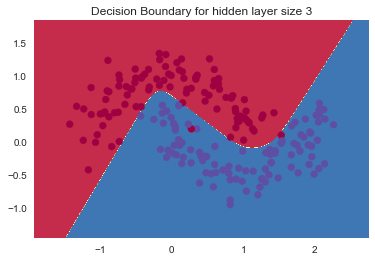

In [104]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

##  Varying the hidden layer size

<Figure size 1152x2304 with 0 Axes>

Text(0.5,1,'Hidden Layer size 1')

Text(0.5,1,'Hidden Layer size 2')

Text(0.5,1,'Hidden Layer size 3')

Text(0.5,1,'Hidden Layer size 4')

Text(0.5,1,'Hidden Layer size 5')

Text(0.5,1,'Hidden Layer size 20')

Text(0.5,1,'Hidden Layer size 50')

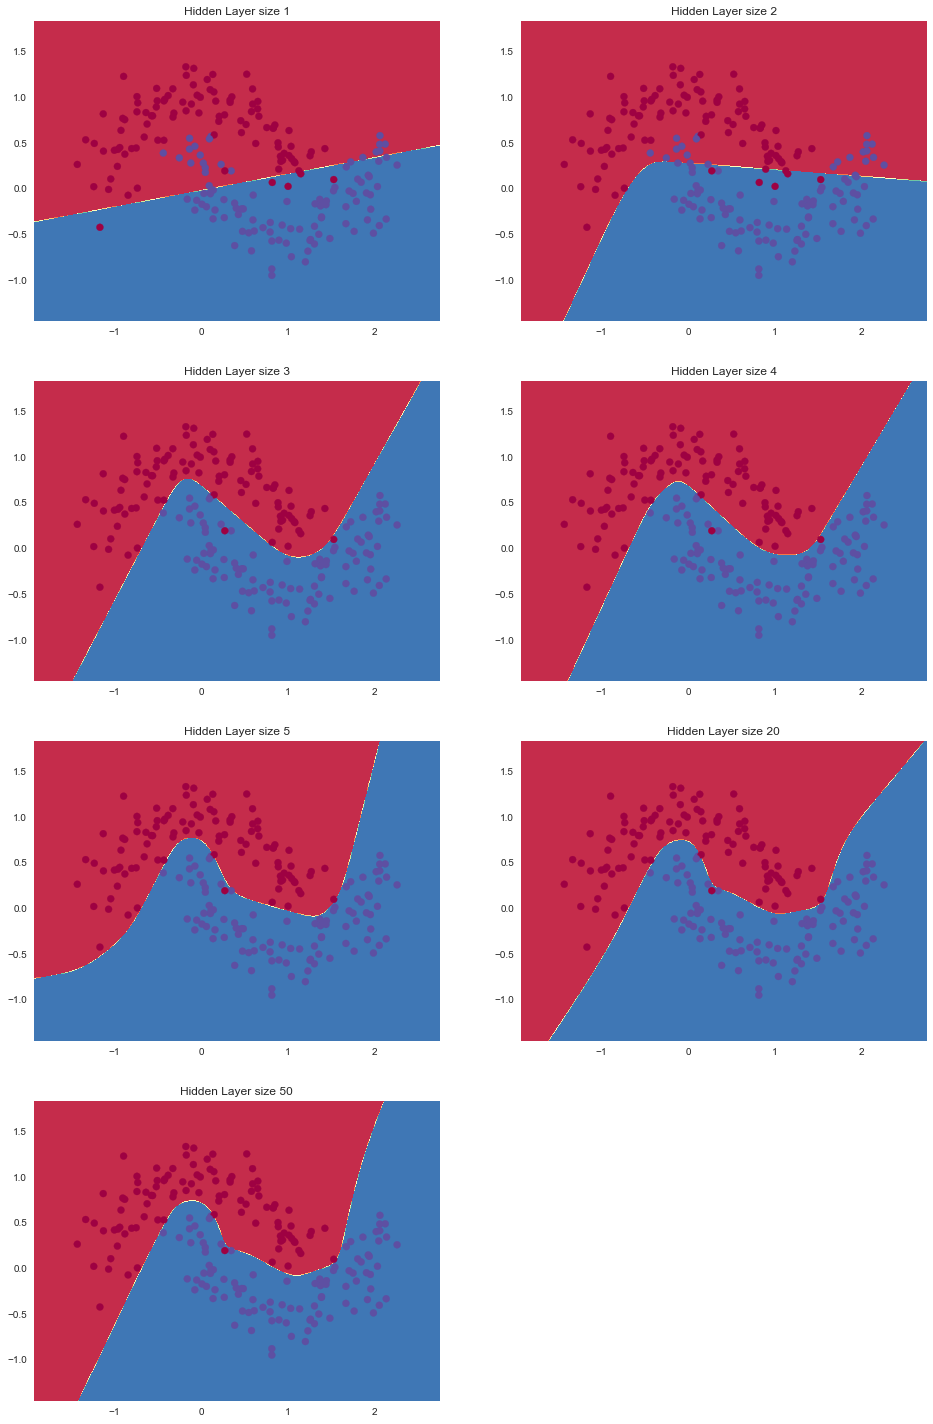

In [105]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()